In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import *

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [6]:
!kaggle datasets download felipekitamura/spr-x-ray-age-and-gender-dataset -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/felipekitamura/spr-x-ray-age-and-gender-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 15.6G/15.6G [09:03<00:00, 37.1MB/s]
100% 15.6G/15.6G [09:03<00:00, 30.8MB/s]


In [7]:

df_age = pd.read_csv('/content/train_age.csv')
df_gender = pd.read_csv('/content/train_gender.csv')

print(df_age.head())
print(df_gender.head())

   imageId   age
0        0  89.0
1        1  72.0
2        2  25.0
3        3  68.0
4        4  37.0
   imageId  gender
0        0       0
1        1       0
2        2       1
3        3       1
4        4       0


In [8]:
im = []
for i in tqdm(sorted(os.listdir('/content/kaggle/kaggle/train/'))):
    img = cv2.imread('/content/kaggle/kaggle/train/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255-img # creating the negative of the image
    img = cv2.resize(img,(128, 128))
    im.append(img)
    #img.append(plt.imread(dir+'kaggle/kaggle/train/'+i))
age = df_age['age']
gen= df_gender['gender']
data ={'Image': im,'Age':age,'Gender':gen}


100%|██████████| 10702/10702 [05:55<00:00, 30.08it/s]


In [9]:
df = pd.DataFrame(data)

In [10]:
df.head(5)

,Image,Age,Gender
0,"[[189, 236, 251, 250, 249, 247, 249, 247, 248,...",89.0,0
1,"[[236, 254, 254, 254, 254, 254, 254, 254, 254,...",72.0,0
2,"[[201, 253, 255, 255, 255, 255, 255, 255, 255,...",25.0,1
3,"[[255, 255, 255, 251, 215, 226, 230, 232, 232,...",68.0,1
4,"[[248, 248, 248, 248, 248, 248, 248, 248, 248,...",37.0,0


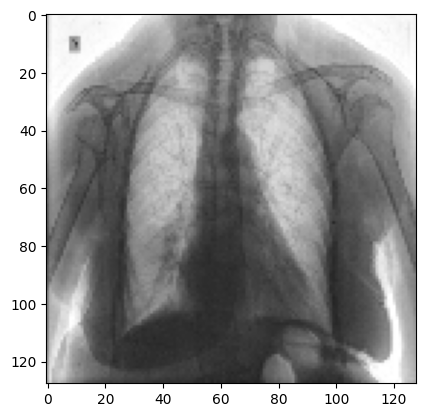

In [11]:
plt.imshow(
    cv2.cvtColor(df['Image'].iloc[0], cv2.COLOR_BGR2RGB)
)

# Gender Prediction

In [12]:
X = np.array(data['Image'])
y = np.array(data['Gender'])

X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
y = y.reshape(-1,1)
X = X/255
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702, 1)


# Gender DCNN model

In [13]:
def blockc(y,filt,kern):
    x = tensorflow.keras.layers.Conv2D(filt,kern, padding = 'same')(y)
    x = tensorflow.keras.layers.MaxPool2D(2 , strides = 2, padding = 'same')(x)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [14]:
tensorflow.keras.backend.clear_session()
model_gender = tensorflow.keras.Sequential()

inp = tensorflow.keras.layers.Input((128,128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)

out = tensorflow.keras.layers.Dense(1, activation = 'sigmoid')(c6)

model_gender = tensorflow.keras.Model(inputs = inp, outputs = out)
model_gender.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 191,257 (747.10 KB)

 Trainable params: 190,585 (744.47 KB)

 Non-trainable params: 672 (2.62 KB)

In [15]:
model_gender.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


In [16]:
history = model_gender.fit(
    X,y,
    epochs = 10,
    validation_split = 0.2
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.7325 - loss: 0.5124 - val_accuracy: 0.3545 - val_loss: 1.1320
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9095 - loss: 0.2387 - val_accuracy: 0.9318 - val_loss: 0.1758
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9433 - loss: 0.1632 - val_accuracy: 0.9005 - val_loss: 0.2462
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9477 - loss: 0.1471 - val_accuracy: 0.7230 - val_loss: 0.6511
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9592 - loss: 0.1267 - val_accuracy: 0.9211 - val_loss: 0.2086
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9633 - loss: 0.0993 - val_accuracy: 0.9533 - val_loss: 0.1308
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9737 - loss: 0.0838 - val_accuracy: 0.9542 - val_loss: 0.1321
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9702 - loss: 0.0796 - val_accuracy

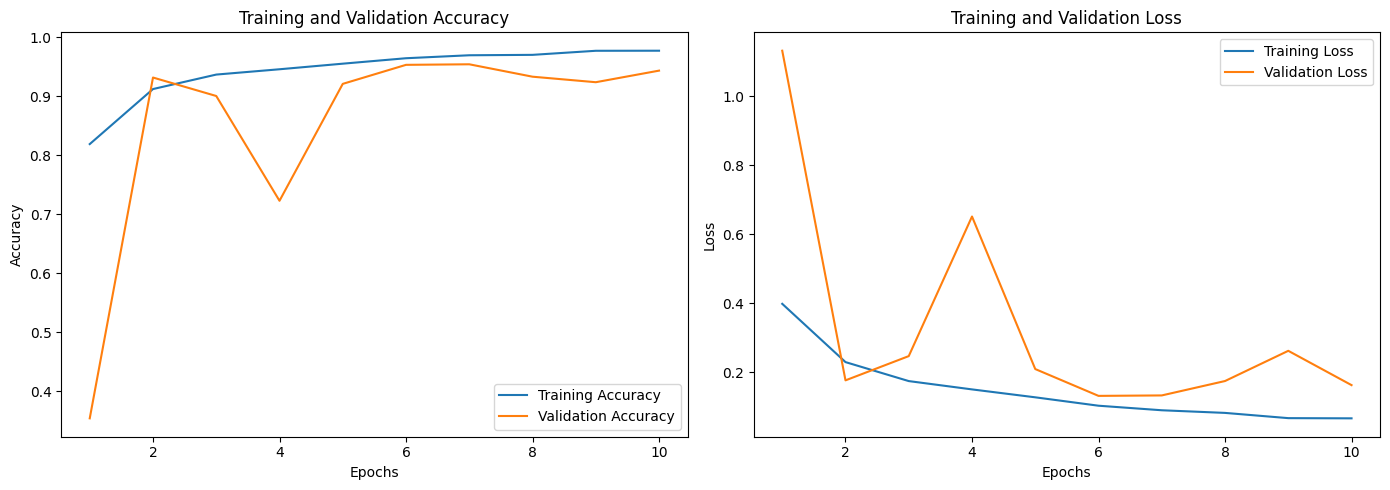

In [17]:
# Plot Accuracy and Loss Curves
def plot_training_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    # Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

In [18]:
model_gender.save('model_gender.keras')

# Age Prediction

In [19]:
y = np.array(data['Age'])
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702,)


In [20]:
tensorflow.keras.backend.clear_session()
model_age = tensorflow.keras.Sequential()


inp = tensorflow.keras.layers.Input((128, 128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
c7 = tensorflow.keras.layers.Flatten()(c6)
c8 = tensorflow.keras.layers.Dense(100,activation='linear')(c7)
c9 = tensorflow.keras.layers.Dense(50,activation='linear')(c8)
out = tensorflow.keras.layers.Dense(1,activation='linear')(c9)
model_age = tensorflow.keras.Model(inputs = [inp], outputs = [out])


In [21]:
model_age.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam',
    metrics = ['mse']
)

model_age.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 199,625 (779.79 KB)

 Trainable params: 198,953 (777.16 KB)

 Non-trainable params: 672 (2.62 KB)

In [22]:
history = model_age.fit(
    X, y,
    epochs = 25,
    validation_split = 0.2
)


Epoch 1/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 1097.7830 - mse: 1097.7830 - val_loss: 553.6786 - val_mse: 553.6786
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 138.7930 - mse: 138.7930 - val_loss: 204.4238 - val_mse: 204.4238
Epoch 3/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 109.3229 - mse: 109.3229 - val_loss: 179.0511 - val_mse: 179.0511
Epoch 4/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 94.6947 - mse: 94.6947 - val_loss: 143.6700 - val_mse: 143.6700
Epoch 5/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 83.9071 - mse: 83.9071 - val_loss: 94.2465 - val_mse: 94.2465
Epoch 6/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 76.0235 - mse: 76.0235 - val_loss: 107.7058 - val_mse: 107.7058
Epoch 7/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 67.7465 - mse: 67.7465 - val_loss: 161.2879 - val_mse: 161.2879
Epoch 8/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 60.6283 - mse: 60.6283 - val_loss: 90.2071 - val_mse: 90.2071
Ep

<Axes: >

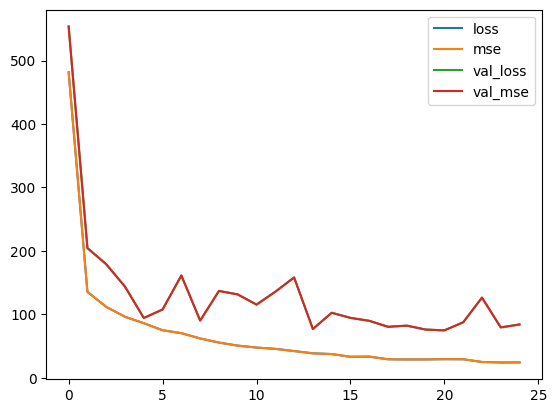

In [23]:
pd.DataFrame(
    history.history
).plot()


In [24]:
model_age.save('model_age.keras')

# Testing the models

In [25]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = model_gender.predict(X)
pred = []
for i in tqdm(y_pred):
    if i<0.5:
        pred.append(0)
    else:
        pred.append(1)
pred = np.array(pred)

print(pred.shape,y.shape)
print(pred[5:15],gen[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


100%|██████████| 10702/10702 [00:00<00:00, 345301.29it/s]

(10702,) (10702,)
[1 1 1 0 1 0 1 1 0 1] 5     1
6     1
7     1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
Name: gender, dtype: int64


In [26]:
pred = np.round(model_gender.predict(X))
print(pred[5:15],age[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]] 5     62.0
6     52.0
7     46.0
8     83.0
9     33.0
10    82.0
11    78.0
12    61.0
13    74.0
14    28.0
Name: age, dtype: float64


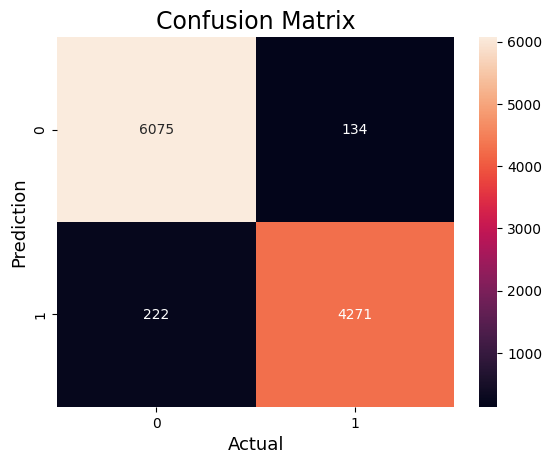

Accuracy   : 0.9667351896841712
Precision : 0.9695800227014756
Recall    : 0.9505898063654574
F1-score  : 0.959991009215554


In [27]:
import seaborn as sns
cm = confusion_matrix(gen,pred)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
accuracy = accuracy_score(gen, pred)
print("Accuracy   :", accuracy)
precision = precision_score(gen, pred)
print("Precision :", precision)
recall = recall_score(gen, pred)
print("Recall    :", recall)
F1_score = f1_score(gen, pred)
print("F1-score  :", F1_score)


In [28]:
from sklearn.metrics import r2_score

p = model_age.predict(X)

print(r2_score(age,p))

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
0.8310051115219839


# Testing

In [34]:
# Define function to load and preprocess images
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_test_images(test_dir, target_size=(128, 128)):
    images = []
    filenames = []
    for file in os.listdir(test_dir):
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            # Load and preprocess image
            img = load_img(os.path.join(test_dir, file), color_mode='grayscale', target_size=target_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            filenames.append(file)
    return np.array(images), filenames

# Load test images
test_images, test_filenames = load_test_images(test_data)


In [35]:
# Predict age and gender
predicted_ages = model_age.predict(test_images)
predicted_genders = model_gender.predict(test_images)

# Convert gender predictions to binary (0 or 1)
predicted_genders_binary = (predicted_genders > 0.5).astype(int)



368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


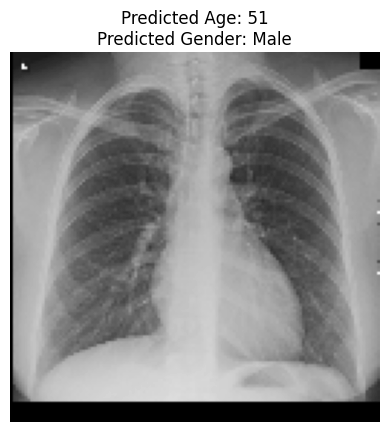

----------------------------------------


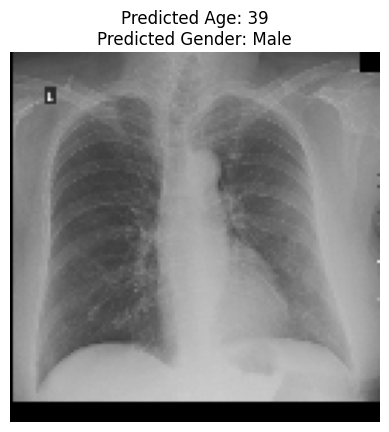

----------------------------------------


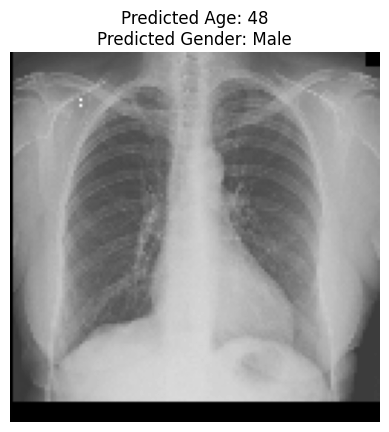

----------------------------------------


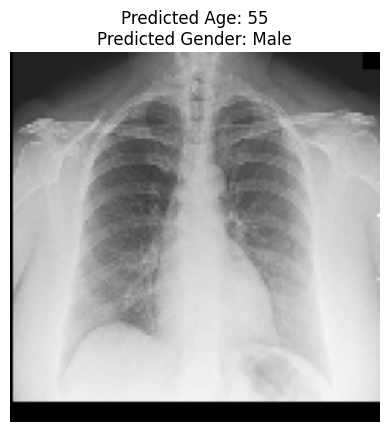

----------------------------------------


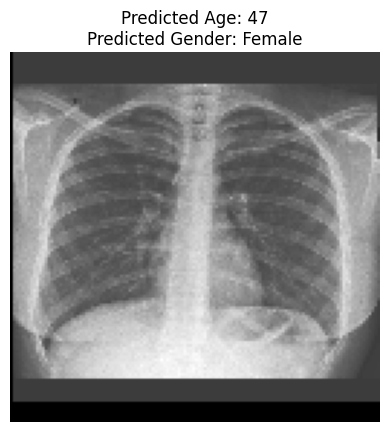

----------------------------------------


In [39]:
# Display predictions for only the first 5 images
for i in range(min(5, len(test_filenames))):  # Limit to 5 images
    filename = test_filenames[i]
    predicted_age_int = int(predicted_ages[i][0])  # Get the integer part of the predicted age
    plt.imshow(test_images[i], cmap='gray')  # Show image in grayscale
    plt.title(f"Predicted Age: {predicted_age_int}\n"
              f"Predicted Gender: {'Male' if predicted_genders_binary[i][0] == 1 else 'Female'}")
    plt.axis('off')  # Hide axis
    plt.show()  # Display image
    print("-" * 40)
